Sage Hahn

**Data Science Final Project**

An initial data exploration into the redditTextBlocks without any prior pre-processing. The main goal is to test how the ratio of subject X to not subject X affects training a classifier.

In [1]:
import os
import pickle
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
read_path = 'data/redditTextBlock1.pkl'

#Read in the first post chunk
posts = []
with open(read_path, 'rb') as fp:
    posts = pickle.load(fp)

In [3]:
#Very basic pre-processing at this step, just lowercase
#Later on could try something like stemming or tokenizing very early
for i in range(len(posts)):
    posts[i] = posts[i].lower()

In [4]:
#Store all instances of class X in the topic array
topic_array = []

#Lets test a simple example with some key words about say fishing
key_words = ['fishing', 'caught fish', 'catching fish']

for line in posts:
    for key in key_words:
        if key in line:
            topic_array.append(line)
            
len(topic_array)

3388

Alright interesting, the basic key word search found 3388 instances for fishing, though this is of course out of 10 million posts. It is probally safe to say that there are more posts about fishing... but this is a good start.

In [5]:
#Let's initialize an array of not topic X, to use with the classifier.
not_topic = []

#The other number to play arround with is how many examples of not_topic to use,
#lets start with 5 times the amount.
numNotX = len(topic_array) * 5

for line in posts[:numNotX]:
    
    #Note: not the most effecient code, but should be fine on this scale
    if line not in topic_array:
        not_topic.append(line)
        
len(not_topic)

16939

Alright now we have two arrays, one about fishing, and one 5 times larger not about fishing, lets now try a basic sklearn pipeline and text classifier on the data.

In [6]:
#Declare the pipeline/classifier
classifier = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                               ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=10)),])

In [7]:
#Combine the arrays in X, and add class values in y, 1 for about topic, 0 for not.
X = []
y = []

for line in topic_array:
    X.append(line)
    y.append(1)
    
for line in not_topic:
    X.append(line)
    y.append(0)

In [8]:
#Fit the classifier
classifier.fit(X,y)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [9]:
#Now use the classifier on the chunk of posts, lets try just the first million
predict = classifier.predict(posts[:1000000])

Note just using a million for now because higher numbers take too long, and this is just an initial data exploration

In [10]:
predict_posts = []

#Go through and see which posts were labelled 1 by the classifier
for num in range(len(predict)):
    if (predict[num] == 1):
        predict_posts.append(posts[num])

len(predict_posts)

213

210... Alright so that's a pretty small number, though we used only 1/10 of the dataset, assuming that number remains the same, in the whole dataset it would find ~2100, vs. the 3388 found by just a keyword search. Also at this point we can note there have been a few key variables, the first is how much data we use in not_topic, and the second being how the pipeline and classifier is setup. For now lets examine how the first relationship plays out between ratio of X to not X.

In [11]:
#Lets write a function, not a complete one, we'll assume posts is global, and a few other things (the classifier),
#The purpose of the function just to automate the process we just went through
def predictor(input_array, notXRatio):
    
    
    #Init not topic
    not_topic = []

    #Set based on ratio
    numNotX = len(input_array) * notXRatio

    for line in posts[:numNotX]:
    
        if line not in input_array:
            not_topic.append(line)
            
    #Combine the arrays in X, and add class values in y, 1 for about topic, 0 for not.
    X = []
    y = []

    for line in input_array:
        X.append(line)
        y.append(1)

    for line in not_topic:
        X.append(line)
        y.append(0)
        
    #Fit the classifier
    classifier.fit(X,y)
    
    #Now use the classifier on the chunk of posts, lets try just the first million
    predict = classifier.predict(posts[:1000000])
    
    predict_posts = []

    #Go through and see which posts were labelled 1 by the classifier
    for num in range(len(predict)):
        if (predict[num] == 1):
            predict_posts.append(posts[num])

    return (predict_posts)

Alright with a copy of the steps from above in a function we can explore how the number changes with different ratios, and different keyword searches, note at this point were not even concerned with the actual results were getting just the number.

In [12]:
#Create a 'reduced' topic array, of posts found by keyword search in only the first million,
reduced_topic_array = []

for line in posts[:1000000]:
    for key in key_words:
        if key in line:
            reduced_topic_array.append(line)

In [13]:
lengths = []
ratios = []

for x in range(1,16):
    p_posts = predictor(topic_array, x)
    
    lengths.append(len(p_posts))
    ratios.append(x)
    
    print(len(p_posts),"with ratio: ", x)
    
    count = 0;
    for line in p_posts:
        if line in reduced_topic_array:
            count += 1
            
    print(count, "overlap with  reduced topic_array")
            

313
95946 with ratio:  1
301 overlap with  reduced topic_array
18138 with ratio:  2
284 overlap with  reduced topic_array
1372 with ratio:  3
237 overlap with  reduced topic_array
260 with ratio:  4
172 overlap with  reduced topic_array
210 with ratio:  5
146 overlap with  reduced topic_array
184 with ratio:  6
133 overlap with  reduced topic_array
158 with ratio:  7
122 overlap with  reduced topic_array
134 with ratio:  8
112 overlap with  reduced topic_array
126 with ratio:  9
111 overlap with  reduced topic_array
117 with ratio:  10
107 overlap with  reduced topic_array
105 with ratio:  11
99 overlap with  reduced topic_array
98 with ratio:  12
93 overlap with  reduced topic_array
94 with ratio:  13
89 overlap with  reduced topic_array
88 with ratio:  14
84 overlap with  reduced topic_array
82 with ratio:  15
79 overlap with  reduced topic_array


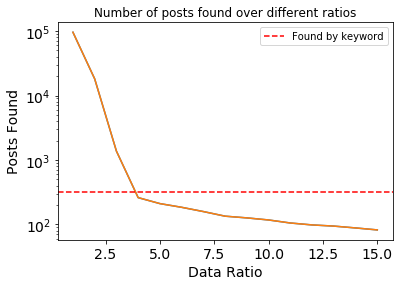

In [24]:
import matplotlib.pyplot as plt

#First plot the f1 ratios
plt.plot(ratios,lengths)

plt.axhline(y=len(reduced_topic_array), color='r', linestyle='dashed', label = "Found by keyword")

title = "Number of posts found over different ratios"
plt.title(title)
plt.xlabel("Data Ratio", fontsize=14)
plt.ylabel("Posts Found", fontsize=14)
plt.yscale('log') 

plt.legend()

plt.tick_params(labelsize=14) 
plt.show()

In [15]:
p_posts = predictor(topic_array, 4)

After a little actually looking at the posts, 4 seems to be about where it is safe, and most of the posts seem to be about fishing. A ratio of 3 was... uh very very mixed. With that in mind 4 seems like a pretty safe place to keep the ratio hyperparameter as I start expirimenting with other pre-processing and classifier models.

Also interestingly, the reduced overlap number tells us that we have almost 100 'new' results, note that the number tightens up as the ratio is increased, with ratio 12 for example, only 5 'new' results. This confirms a suspision of mine that the ratio can be used to trade off accuracy and percision.

In [16]:
p_posts = predictor(topic_array, 15)

In [17]:
p_posts

["so you weren't really asking a question but fishing for validation in your own thoughts?",
 '    8/m \n    kodiak, alaska\n    hobbies include fishing, sleeping, staying warm and more fishing\n    looking for a pretty, alpha female to mate with, potentially for more than one season.',
 "thanks but not interested in fishing shiny's\n",
 'why fish sharks in catherby when you can fish in the fishing guild?',
 'shit i shoulda trained that instead of fishing',
 "they're fishing sharks, and you're under the impression they're trying to be efficient.",
 'fishing for a complement is 1k tastes is 100.',
 "no problem, it's much easier than fishing in the container to get equal meat and liquid",
 "i've only been fly fishing for a couple weeks and fly tying for about 5 days. ",
 "it's like you're actually fishing for hatemail with the decapitate emote.\n\nvery good!",
 'i should probably start doing this. always feel stupid sitting on the bank trying to get the eye open so i can go back to fishi